In [9]:
# -------------------------------------------------------------------
# --- Final Project: Heart Disease Prediction (Full Pipeline) ---
# -------------------------------------------------------------------
# This script covers the entire machine learning workflow:
# 1. Setup and Data Loading
# 2. Exploratory Data Analysis (EDA) with Visualization
# 3. ETL and Feature Engineering
# 4. Model Training and Hyperparameter Tuning
# 5. Final Model Evaluation and Interpretation
# -------------------------------------------------------------------

# 1. SETUP AND DATA LOADING
# -------------------------------------------------------------------
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
import warnings


In [13]:
import pandas as pd

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
try:
    df = pd.read_csv('/content/drive/My Drive/MIS512/Final/heart.csv')
    print("✅ Data loaded successfully! First few rows:")
    print(df.head(5))
except FileNotFoundError:
    print("Error: heart.csv not found. Please make sure the file is in the correct location in your Google Drive.")
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded successfully! First few rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  




---
| 2. EXPLORATORY DATA ANALYSIS (EDA)
---


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
--------------------

--- Descriptive Statistics (Numerical Features) ---
              Age   RestingBP  Cholesterol   FastingBS    

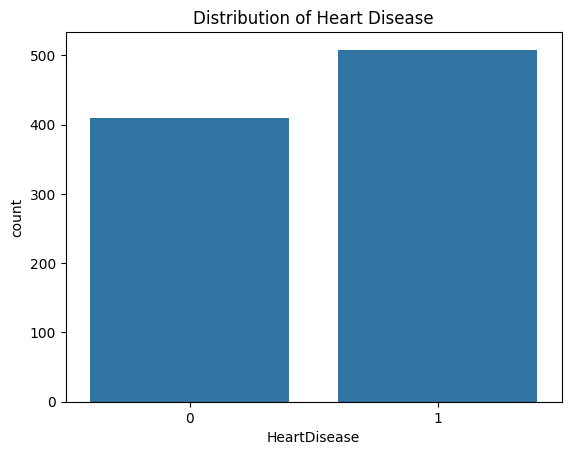


Interpretation:
The dataset is fairly balanced, with slightly more patients having heart disease (508)
than not (410). This means we don't need to use complex techniques like SMOTE for
class imbalance.


--- Visualizing Numerical Feature Distributions ---


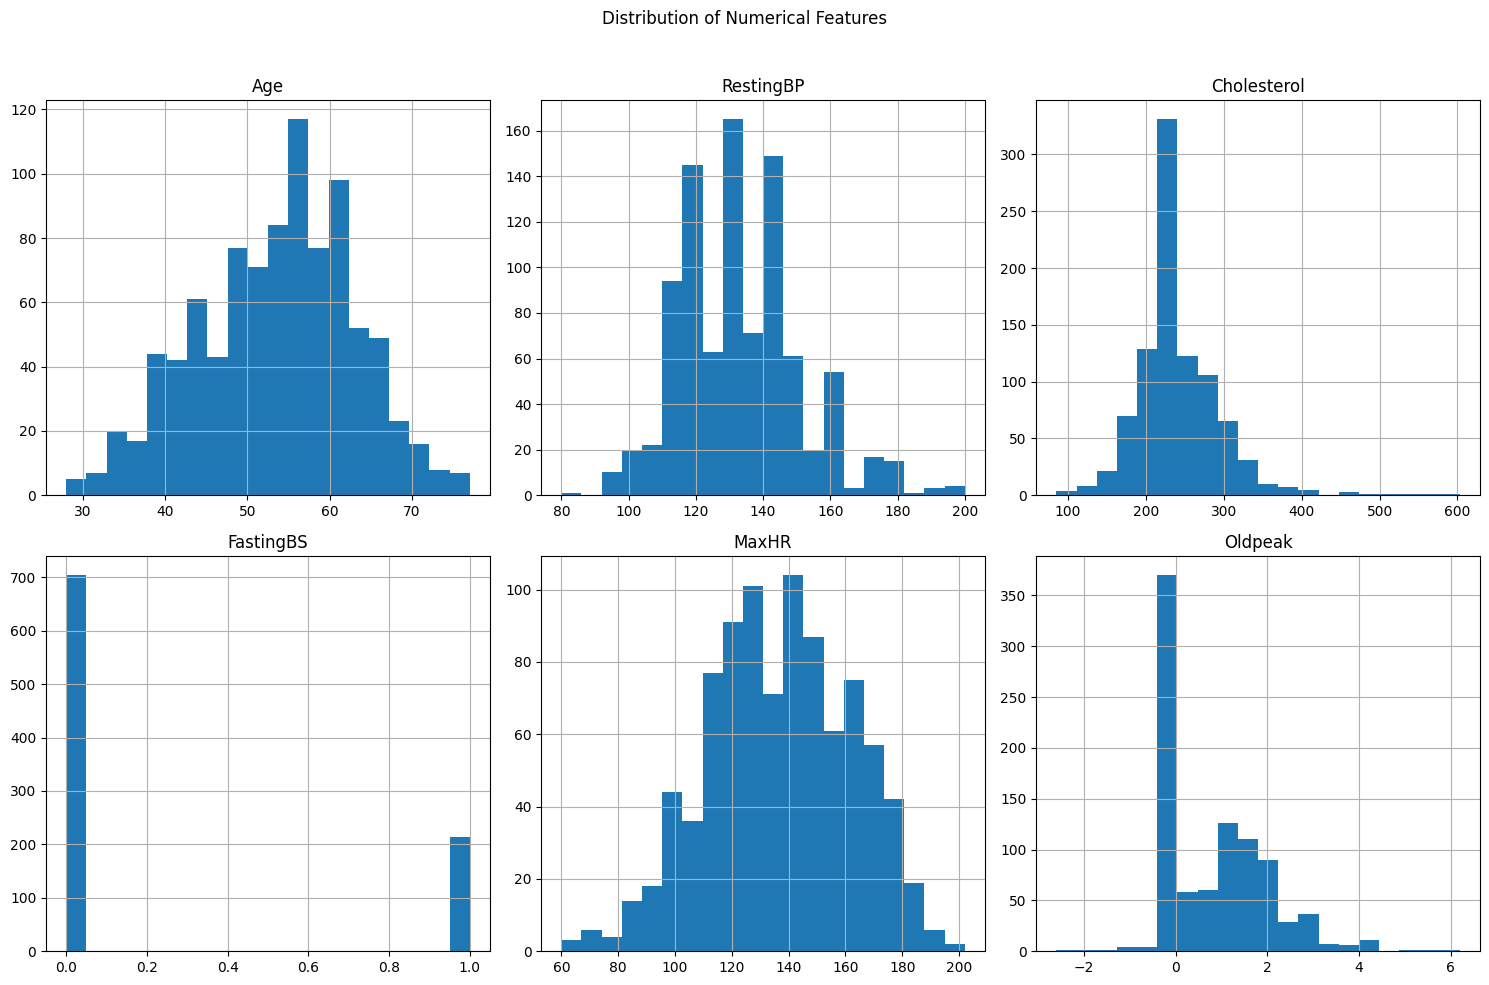


Interpretation:
- Age and MaxHR appear to be somewhat normally distributed.
- RestingBP and Cholesterol are skewed by the '0' values, which we will clean.
- Oldpeak is heavily skewed to the right, indicating most values are low.


--- Correlation Matrix of Numerical Features ---


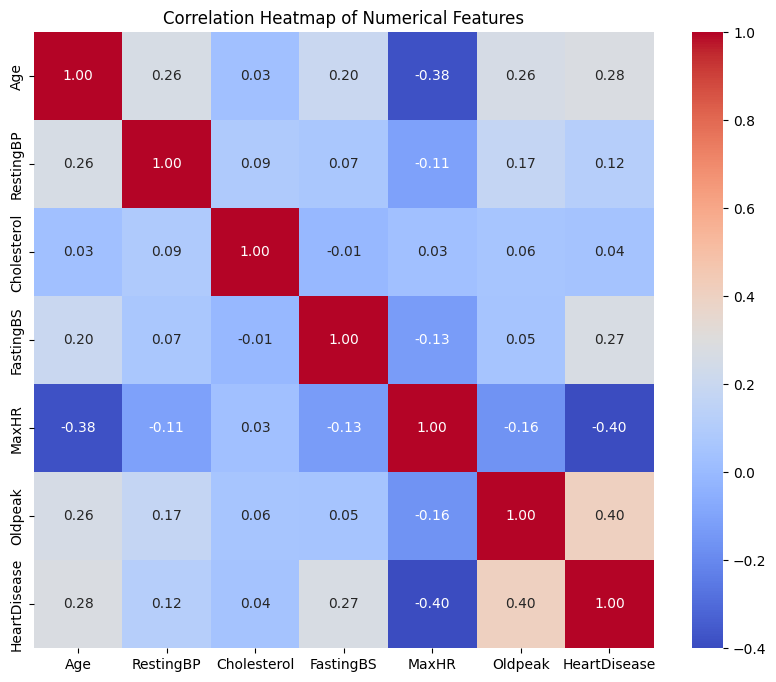


Interpretation:
- MaxHR has a moderate negative correlation with HeartDisease (-0.40). Lower maximum heart
  rate is associated with a higher chance of heart disease.
- Oldpeak has a moderate positive correlation with HeartDisease (0.40). Higher ST depression
  is associated with a higher chance of heart disease.
- Age also shows a positive correlation (0.28).
- There are no extremely high correlations between independent features, reducing concerns
  about multicollinearity.



In [19]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# -------------------------------------------------------------------
print("\n\n---\n| 2. EXPLORATORY DATA ANALYSIS (EDA)\n---\n")

# --- Basic Information ---
print("\n--- Dataset Info ---")
df.info()
print("-" * 20)

# --- Descriptive Statistics for Numerical Features ---
print("\n--- Descriptive Statistics (Numerical Features) ---")
print(df.describe())
print("-" * 50)
print("""
Interpretation:
- Age: The patient ages range from 28 to 77, with an average of 53.5.
- RestingBP & Cholesterol: Both have minimum values of 0, which are physiologically impossible.
  These are likely data errors and will be handled in the ETL phase.
- MaxHR: Maximum heart rate achieved varies widely from 60 to 202.
""")

# --- Distribution of Categorical Features ---
print("\n--- Distribution of Categorical Features ---")
categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())
print("-" * 40)
print("""
Interpretation:
- Sex: The dataset is predominantly male (78.9%).
- ChestPainType: 'ASY' (Asymptomatic) is the most common type, which is a key indicator.
- RestingECG: 'Normal' is the most frequent result.
- ExerciseAngina: More patients do not have exercise-induced angina ('N').
- ST_Slope: 'Flat' and 'Up' are the most common ST slope patterns.
""")

# --- Target Variable Distribution ---
print("\n--- Target Variable (HeartDisease) Distribution ---")
print(df['HeartDisease'].value_counts())
sns.countplot(x='HeartDisease', data=df)
plt.title('Distribution of Heart Disease')
plt.show()
print("""
Interpretation:
The dataset is fairly balanced, with slightly more patients having heart disease (508)
than not (410). This means we don't need to use complex techniques like SMOTE for
class imbalance.
""")


# --- Visualization of Numerical Feature Distributions ---
print("\n--- Visualizing Numerical Feature Distributions ---")
numerical_features = df.select_dtypes(include=np.number).columns.drop('HeartDisease')
df[numerical_features].hist(bins=20, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("""
Interpretation:
- Age and MaxHR appear to be somewhat normally distributed.
- RestingBP and Cholesterol are skewed by the '0' values, which we will clean.
- Oldpeak is heavily skewed to the right, indicating most values are low.
""")


# --- Correlation Heatmap ---
print("\n--- Correlation Matrix of Numerical Features ---")
# We compute the correlation matrix only on numerical columns
numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()
print("""
Interpretation:
- MaxHR has a moderate negative correlation with HeartDisease (-0.40). Lower maximum heart
  rate is associated with a higher chance of heart disease.
- Oldpeak has a moderate positive correlation with HeartDisease (0.40). Higher ST depression
  is associated with a higher chance of heart disease.
- Age also shows a positive correlation (0.28).
- There are no extremely high correlations between independent features, reducing concerns
  about multicollinearity.
""")

In [15]:

# 3. ETL & FEATURE ENGINEERING
# -------------------------------------------------------------------
print("\n\n---\n| 3. ETL & FEATURE ENGINEERING\n---\n")

# --- Data Cleaning (TRANSFORM step of ETL) ---
print("\n--- Cleaning Data ---")
# Drop duplicates
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")

# Correct the physiologically impossible '0' values in RestingBP and Cholesterol
# by replacing them with the median of the respective column.
for col in ['RestingBP', 'Cholesterol']:
    median_val = df[col].median()
    num_zeros = (df[col] == 0).sum()
    if num_zeros > 0:
        df[col] = df[col].replace(0, median_val)
        print(f"Replaced {num_zeros} zero values in '{col}' with the median value ({median_val}).")
print("✅ Data cleaning complete.")

# --- Feature Engineering Pipeline ---
# Separate features (X) and target (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Re-identify numerical and categorical features after cleaning
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines for numerical and categorical data
# 1. Numerical features will be scaled to have a mean of 0 and std deviation of 1.
# 2. Categorical features will be converted into numerical format using one-hot encoding.
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Bundle preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("\n✅ Preprocessing and feature engineering pipeline created.")



---
| 3. ETL & FEATURE ENGINEERING
---


--- Cleaning Data ---
Removed 0 duplicate rows.
Replaced 1 zero values in 'RestingBP' with the median value (130.0).
Replaced 172 zero values in 'Cholesterol' with the median value (223.0).
✅ Data cleaning complete.

✅ Preprocessing and feature engineering pipeline created.


In [16]:

# 4. MODEL TRAINING & HYPERPARAMETER TUNING
# -------------------------------------------------------------------
print("\n\n---\n| 4. MODEL TRAINING & HYPERPARAMETER TUNING\n---\n")

# --- Train-Test Split ---
# Split data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split into {X_train.shape[0]} training samples and {X_test.shape[0]} testing samples.")

# --- Model Pipeline and Hyperparameter Tuning ---
# Define the model to be used: RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Create the full pipeline: Preprocessor -> Classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Define the grid of hyperparameters to search through
# Using a smaller, more focused grid for demonstration purposes
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Set up GridSearchCV to find the best parameters using 5-fold cross-validation
# We optimize for 'recall' as it's crucial to identify as many true cases as possible
print("\n🚀 Starting hyperparameter tuning with GridSearchCV...")
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model found by the grid search
best_model = grid_search.best_estimator_

print("\n✅ Hyperparameter tuning complete.")
print(f"Best Recall Score from CV: {grid_search.best_score_:.4f}")
print(f"Best Parameters Found: {grid_search.best_params_}")




---
| 4. MODEL TRAINING & HYPERPARAMETER TUNING
---

Data split into 734 training samples and 184 testing samples.

🚀 Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Hyperparameter tuning complete.
Best Recall Score from CV: 0.9038
Best Parameters Found: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}




---
| 5. FINAL MODEL EVALUATION & INTERPRETATION
---


📊 Evaluating the best model on the unseen test set...

--- Final Evaluation Metrics ---
Accuracy:  0.8641
Precision: 0.8889
Recall:    0.8627  <-- Key metric for medical diagnosis
F1-Score:  0.8756
AUC-ROC:   0.9226
------------------------------

--- Classification Report ---
                  precision    recall  f1-score   support

No Heart Disease       0.84      0.87      0.85        82
   Heart Disease       0.89      0.86      0.88       102

        accuracy                           0.86       184
       macro avg       0.86      0.86      0.86       184
    weighted avg       0.87      0.86      0.86       184

-----------------------------

--- Confusion Matrix ---


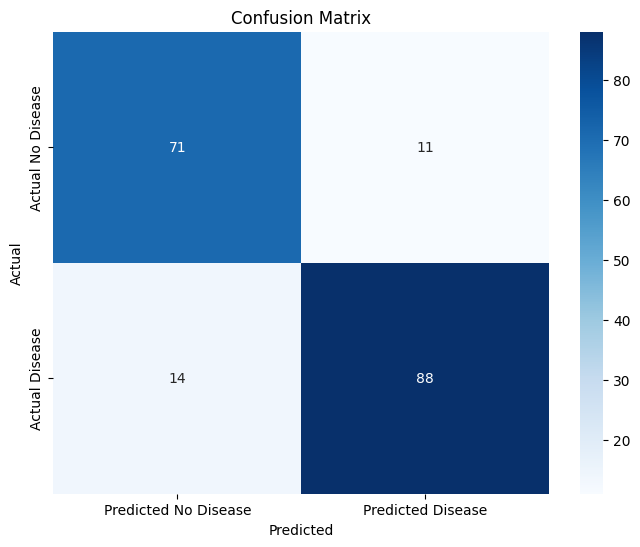


Interpretation of Confusion Matrix:
- The diagonal values show the number of correct predictions (True Positives and True Negatives).
- The off-diagonal values show the number of incorrect predictions (False Positives and False Negatives).
- For heart disease prediction, minimizing False Negatives (missing a case of heart disease) is crucial, which is reflected in the Recall score.

--- Feature Importance (for Tree-based models) ---
# This section is only relevant if using tree-based models like RandomForest or Gradient Boosting.
# Uncomment and run if you want to see feature importances.
# try:
#     if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
#         importances = best_model.named_steps['classifier'].feature_importances_
#         feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
#         feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
#         feature_importance_df = feature_i

In [18]:
# 5. FINAL MODEL EVALUATION & INTERPRETATION
# -------------------------------------------------------------------
print("\n\n---\n| 5. FINAL MODEL EVALUATION & INTERPRETATION\n---\n")
print("\n📊 Evaluating the best model on the unseen test set...")

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# --- Calculate and Display Metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n--- Final Evaluation Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}  <-- Key metric for medical diagnosis")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}")
print("-" * 30)

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Heart Disease', 'Heart Disease']))
print("-" * 29)

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Disease', 'Predicted Disease'],
            yticklabels=['Actual No Disease', 'Actual Disease'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("""
Interpretation of Confusion Matrix:
- The diagonal values show the number of correct predictions (True Positives and True Negatives).
- The off-diagonal values show the number of incorrect predictions (False Positives and False Negatives).
- For heart disease prediction, minimizing False Negatives (missing a case of heart disease) is crucial, which is reflected in the Recall score.

--- Feature Importance (for Tree-based models) ---
# This section is only relevant if using tree-based models like RandomForest or Gradient Boosting.
# Uncomment and run if you want to see feature importances.
# try:
#     if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
#         importances = best_model.named_steps['classifier'].feature_importances_
#         feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
#         feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
#         feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

#         print("\n--- Feature Importances ---")
#         print(feature_importance_df.head(10)) # Display top 10 features

#         plt.figure(figsize=(10, 6))
#         sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
#         plt.title('Top 10 Feature Importances')
#         plt.show()
#         print("-" * 27)

# except Exception as e:
#     print(f"\nCould not display feature importances: {e}")


print("\n✅ Model evaluation complete.")
""")